#DATAFRAME BverfG

In [1]:
### GERMANY ###

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

url_prefix = "https://www.bundesverfassungsgericht.de/SiteGlobals/Forms/Suche/Entscheidungensuche_Formular.html?gts=5403124_list%253DdateOfIssue_dt%252Basc&submit=Senden&dateAfter=01.01.2018&facettedEntscheidungstyp=Urteil&templateQueryString=EU&dateBefore=01.01.2023&language_=de"
decision_urls = []

for page_num in range(1,2):
    response = requests.get(url_prefix.format(page_num))
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')
    decisions_bverg = soup.find_all('span', class_="aktenzeichen")
    for x in decisions_bverg:
        parent_anchor = x.parent
        if parent_anchor and parent_anchor.has_attr('href'):
            decision_url = parent_anchor["href"]
            decision_urls.append(decision_url)

df = pd.DataFrame(decision_urls)

pd.set_option('display.max_colwidth', None)

decision_url_strings = []

for url in decision_urls:
    url_string = "https://www.bundesverfassungsgericht.de/" + url
    decision_url_strings.append(url_string)


df1 = pd.DataFrame(decision_url_strings, columns=['Decision URLs'])
print(df1)

                                                                                                                                                     Decision URLs
0  https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2018/07/rs20180718_1bvr167516.html;jsessionid=981E91F3808409CD43B703DC781E9CF2.internet971
1  https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2018/09/fs20180919_2bvf000115.html;jsessionid=981E91F3808409CD43B703DC781E9CF2.internet971
2  https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2019/07/rs20190730_2bvr168514.html;jsessionid=981E91F3808409CD43B703DC781E9CF2.internet971
3  https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2020/02/rs20200226_2bvr234715.html;jsessionid=981E91F3808409CD43B703DC781E9CF2.internet971
4  https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2020/05/rs20200505_2bvr085915.html;jsessionid=981E91F3808409CD43B703DC781E9CF2.internet971
5  https://www.bundesv

In [2]:
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

headings = []

for x in decision_url_strings:
    response = requests.get(x)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        indicator_element = soup.find('p', class_='cite')

        if indicator_element:
            element_text = indicator_element.get_text(strip=True)

            terms = element_text.split(' - ')
            headings.extend(terms)
        else:
            print("The element was not found on the webpage.")
    else:
        print(f"Failed to fetch the decision URL: {x}")


print(headings)
len(headings)

df = pd.DataFrame(columns=["Date", "Decision No.", "URL", "Chamber"])

for x in headings:
    date_pattern = r"vom (\d{1,2}\. \w+ \d{4})"
    decision_pattern = r"(\d+ [A-Za-z]+ \d+/\d+)"
    url_pattern = r"https:\/\/www\.bverfg\.de\/e\/[a-z0-9_]+\.[a-z]+"
    chamber_pattern = r"(Ersten|Zweiten) Senats"

    match = re.search(date_pattern, x)
    date = match.group(1) if match else None

    match = re.search(decision_pattern, x)
    decision_no = match.group(1) if match else None

    match = re.search(url_pattern, x)
    url = match.group() if match else None

    match = re.search(chamber_pattern, x)
    chamber = match.group(1) if match else None

    df = df.append({"Date": date, "Decision No.": decision_no, "URL": url, "Chamber": chamber}, ignore_index=True)

print(df)


import re
import pandas as pd
import requests
from bs4 import BeautifulSoup


def find_eu_law(text):
    eu_law_patterns = [
        r"Art\. 267 Abs\. 3 AEUV",
        r"Art\. \d+ Buchstabe [a-z]+ Verordnung \(EU\) Nr\. \d+/\d+ des Rates vom \d+\. [A-Za-z]+ \d+",
        r"Artikel \d+ des Vertrages über die Arbeitsweise der Europäischen Union",
        r"Art\. \d+ Abs\. \d+ [A-Za-z]+ \(EG\) Nr\. \d+/\d+ der Kommission",
        r"Art\. \d+ Abs\. \d+ [A-Za-z]+ EUV",
        r"Art\. \d+ Abs\. \d+ und Abs\. \d+ EUV",
        r"Verordnung <EG> Nr\. \d+/\d+",
        r"Art\. \d+ Abs\. \d+ AEUV",
        r"Beschluss \[EU\] \d+/\d+",
        r"<EU> \d+/\d+",
        r"Verordnung \(EU\) Nr\. \d+/\d+",
        r"ABl EU Nr\. L \d+ vom \d+\. [A-Za-z]+ \d+, S\. \d+",
        r"ABl EU Nr\. L \d+ vom \d+\. [A-Za-z]+ \d+",
        r"EUCO \d+/\d+",
        r"§ \d+ Abs\. \d+ [A-Za-z]+",
        r"ABl EU, L \d+",
        r"EU:C:\d+:\d+"
    ]
    eu_law_matches = []
    for pattern in eu_law_patterns:
        matches = re.findall(pattern, text)
        eu_law_matches.extend(matches)
    return eu_law_matches

for index, row in df.iterrows():
    url = row['URL']
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        text = soup.get_text()
        eu_law = list(set(find_eu_law(text)))
        eu_law_str = ', '.join(eu_law)
        df.at[index, 'EU law'] = eu_law_str
    else:
        print(f"Failed to fetch the URL: {url}")

print(df)


df['Top 50 Words'] = ''

import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')


excluded_words = ['abgabe', 'kommt', 'verfasssungschutzes', "genauigkeit", "antragsgegner","gilt", "hinreichend", "grundlage", "schutz", "januar", "gesetzgeber","gerichtshof", "programm", "maßnahme", "statistische", "parlament" ]
excluded_months = ['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']

import itertools
combinations_of_3_letters = [''.join(comb) for comb in itertools.combinations('abcdefghijklmnopqrstuvwxyz', 3)]
excluded_words.extend(combinations_of_3_letters)

for i, url in enumerate(df['URL']):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text_content = " ".join([p.get_text() for p in soup.find_all('p')])

    stopwords_german = set(stopwords.words('german'))
    text_content = re.sub(r'\W+', ' ', text_content)
    text_content = re.sub(r'\d+', '', text_content)
    tokens = word_tokenize(text_content.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords_german and token not in excluded_words and token not in excluded_months]   # Remove stopwords

    preprocessed_text = " ".join(filtered_tokens)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([preprocessed_text])
    feature_names = vectorizer.get_feature_names_out()

    top_indices = tfidf_matrix.toarray().argsort()[0][-50:]

    top_words = [feature_names[idx] for idx in top_indices]
    df.at[i, 'Top 50 Words'] = ', '.join(top_words)

print(df)

['BVerfG, Urteil des Ersten Senats vom 18. Juli 2018- 1 BvR 1675/16 -, Rn. 1-157,https://www.bverfg.de/e/rs20180718_1bvr167516.html', 'BVerfG, Urteil des Zweiten Senats vom 19. September 2018- 2 BvF 1/15 -, Rn. 1-357,https://www.bverfg.de/e/fs20180919_2bvf000115.html', 'BVerfG, Urteil des Zweiten Senats vom 30. Juli 2019- 2 BvR 1685/14 -, Rn. 1-320,https://www.bverfg.de/e/rs20190730_2bvr168514.html', 'BVerfG, Urteil des Zweiten Senats vom 26. Februar 2020- 2 BvR 2347/15 -, Rn. 1-343,https://www.bverfg.de/e/rs20200226_2bvr234715.html', 'BVerfG, Urteil des Zweiten Senats vom 05. Mai 2020- 2 BvR 859/15 -, Rn. 1-237,https://www.bverfg.de/e/rs20200505_2bvr085915.html', 'BVerfG, Urteil des Ersten Senats vom 19. Mai 2020- 1 BvR 2835/17 -, Rn. 1-332,https://www.bverfg.de/e/rs20200519_1bvr283517.html', 'BVerfG, Urteil des Zweiten Senats vom 02. März 2021- 2 BvE 4/16 -, Rn. 1-86,https://www.bverfg.de/e/es20210302_2bve000416.html', 'BVerfG, Urteil des Ersten Senats vom 26. April 2022- 1 BvR 1619/

<ipython-input-2-a3cff6ecb569>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Date": date, "Decision No.": decision_no, "URL": url, "Chamber": chamber}, ignore_index=True)
<ipython-input-2-a3cff6ecb569>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Date": date, "Decision No.": decision_no, "URL": url, "Chamber": chamber}, ignore_index=True)
<ipython-input-2-a3cff6ecb569>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Date": date, "Decision No.": decision_no, "URL": url, "Chamber": chamber}, ignore_index=True)
<ipython-input-2-a3cff6ecb569>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

                 Date   Decision No.  \
0       18. Juli 2018  1 BvR 1675/16   
1  19. September 2018     2 BvF 1/15   
2       30. Juli 2019  2 BvR 1685/14   
3    26. Februar 2020  2 BvR 2347/15   
4        05. Mai 2020   2 BvR 859/15   
5        19. Mai 2020  1 BvR 2835/17   
6       02. März 2021     2 BvE 4/16   
7      26. April 2022  1 BvR 1619/17   
8    26. Oktober 2022     2 BvE 3/15   
9   06. Dezember 2022   2 BvR 547/21   

                                                  URL  Chamber  \
0  https://www.bverfg.de/e/rs20180718_1bvr167516.html   Ersten   
1  https://www.bverfg.de/e/fs20180919_2bvf000115.html  Zweiten   
2  https://www.bverfg.de/e/rs20190730_2bvr168514.html  Zweiten   
3  https://www.bverfg.de/e/rs20200226_2bvr234715.html  Zweiten   
4  https://www.bverfg.de/e/rs20200505_2bvr085915.html  Zweiten   
5  https://www.bverfg.de/e/rs20200519_1bvr283517.html   Ersten   
6  https://www.bverfg.de/e/es20210302_2bve000416.html  Zweiten   
7  https://www.bverfg.de/e/rs20

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                 Date   Decision No.  \
0       18. Juli 2018  1 BvR 1675/16   
1  19. September 2018     2 BvF 1/15   
2       30. Juli 2019  2 BvR 1685/14   
3    26. Februar 2020  2 BvR 2347/15   
4        05. Mai 2020   2 BvR 859/15   
5        19. Mai 2020  1 BvR 2835/17   
6       02. März 2021     2 BvE 4/16   
7      26. April 2022  1 BvR 1619/17   
8    26. Oktober 2022     2 BvE 3/15   
9   06. Dezember 2022   2 BvR 547/21   

                                                  URL  Chamber  \
0  https://www.bverfg.de/e/rs20180718_1bvr167516.html   Ersten   
1  https://www.bverfg.de/e/fs20180919_2bvf000115.html  Zweiten   
2  https://www.bverfg.de/e/rs20190730_2bvr168514.html  Zweiten   
3  https://www.bverfg.de/e/rs20200226_2bvr234715.html  Zweiten   
4  https://www.bverfg.de/e/rs20200505_2bvr085915.html  Zweiten   
5  https://www.bverfg.de/e/rs20200519_1bvr283517.html   Ersten   
6  https://www.bverfg.de/e/es20210302_2bve000416.html  Zweiten   
7  https://www.bverfg.de/e/rs20

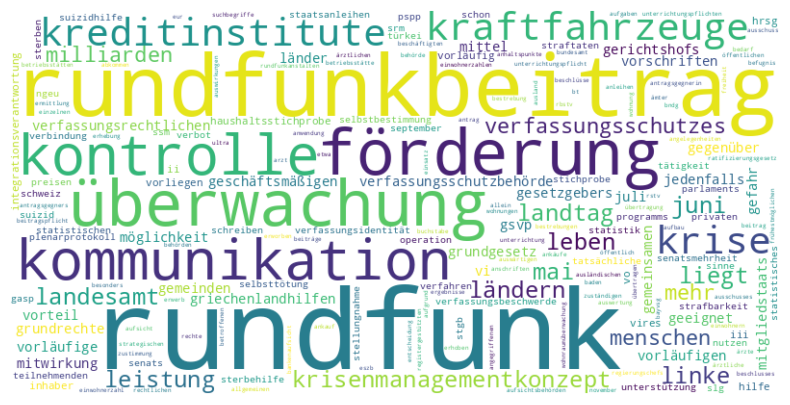

In [3]:
# WORD CLOUD

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

all_words = df['Top 50 Words'].str.cat(sep=', ')

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([all_words])
feature_names = vectorizer.get_feature_names_out()

top_indices = tfidf_matrix.toarray().argsort()[0][-1000:]

top_words = [feature_names[idx] for idx in top_indices]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# DATAFRAME COUR DE CASSATION

NB. Please also refer to the other colab on the Cour de Cassation for other graphs. The dataframes are the same, we just worked on it in different files and used different dataframe names so we could not include the other graphs below.

In [4]:
### FRANCE ###

from requests_oauthlib import OAuth2Session
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import regex as re
import urllib.parse

API_HOST = "https://sandbox-api.aife.economie.gouv.fr"
TOKEN_URL = 'https://sandbox-oauth.aife.economie.gouv.fr/api/oauth/token'
client_id = "b800ee81-4b08-4b7c-9cb6-67f51535888e"
client_secret = "0adff97c-722d-40aa-bbd6-3e32a08c6ae3"

tokencall = requests.post(TOKEN_URL, data={"grant_type": "client_credentials","client_id": client_id, "client_secret": client_secret, "scope": "openid"})

token = tokencall.json()
client = OAuth2Session(client_id, token=token)


keywords = ["règlement UE", "directive", "CHARTE DES DROITS FONDAMENTAUX DE L'UNION EUROPÉENNE", "TFUE", "Traité sur le fonctionnement de l'Union européenne", "Traité sur l'Union européenne"]

all_df_france = []
for key in keywords:
    base_url = "https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/search?query=" + urllib.parse.quote(
        key) +  "&date_start=2018-01-01&date_end=2023-01-01&page_size=50&page="

    df_france = ["", ""]
    ii = 0
    while len(df_france) > 0 and ii < 150:

        resp = client.get(base_url + str(ii))
        results = resp.json()
        df_france = pd.DataFrame(results["results"])
        df_france['keyword'] = key
        all_df_france.append(df_france)
        ii += 1
df_france = pd.concat(all_df_france)

df_france

,score,highlights,id,jurisdiction,chamber,number,numbers,ecli,formation,publication,decision_date,solution,type,summary,themes,files,titlesAndSummaries,keyword,solution_alt
0,1.000000,"{'text': ['ou conservatoires sur le fondement du <em>règlement</em> (<em>UE</em>) n° 1215/2012 doit se prononcer sur la compétence', '<em>UE</em>) n° 1215/2012 du 12 décembre que les dispositions de l'article 8.1 du <em>règlement</em> (<em>UE</em>', '<em>UE</em>) n° 1215/2012 du 12 décembre que le recours à l'article 35 du <em>règlement</em> (<em>UE</em>) n', 'qu'après avoir retenu qu'en application de l'article 35 du <em>règlement</em> (<em>UE</em>) n° 1215/2012 du Parlement', '<em>UE</em> n° 1215/2012 ensemble les dispositions du <em>règlement</em> CE n° 1206/2001 du 28 mai']}",5fca97e33af51f8cc4798830,cc,civ1,16-19.731,[16-19.731],ECLI:FR:CCASS:2018:C100272,fs,[b],2018-03-14,rejet,other,"Aux termes de l'article 35 du règlement (UE) n° 1215/2012 du Parlement européen et du Conseil du 12 décembre 2012, dit Bruxelles I Bis, les mesures provisoires ou conservatoires prévues par la loi d'un Etat membre peuvent être demandées aux juridictions de cet Etat, même si les juridictions d'un autre Etat membre sont compétentes pour connaître du fond. C'est donc à bon droit, et sans avoir à déterminer la juridiction compétente pour connaître du fond, qu'une cour d'appel se déclare compétente pour ordonner, sur le fondement de l'article 145 du code de procédure civile, avant tout procès, une mesure d'expertise devant être exécutée en France et destinée à conserver ou établir la preuve de faits dont pourrait dépendre la solution du litige opposant une société allemande et une société française liées par un contrat comportant une clause d'attribution de compétence aux juridictions allemandes","[union europeenne, règlement (ue) n° 1215/2012 du parlement européen et du conseil du 12 décembre 2012, article 35, mesures provisoires ou conservatoires, juridiction compétente, détermination]",[],[],règlement UE,NaN
1,0.951194,"{'text': ['<em>UE</em> n° 1215/2012 du 12 décembre 2012 (Bruxelles I bis) qu'une personne domiciliée sur le territoire d'un', 'de l'union européenne (CJUE, 12 septembre 2018, Löber, C-304/17) que l'article 7.2 du <em>règlement</em> <em>UE</em> n', '<em>UE</em> n° 1215/2012 du 12 décembre Réponse de la Cour Vu l'article 7 § 2 du <em>règlement</em> (<em>UE</em>', '<em>UE</em> n° 1215/2012 du 12 décembre', '<em>UE</em> n° 1215/2012 du 12 décembre']}",62a9778dc8dc0d05e55423e3,cc,civ1,21-10.742,[21-10.742],ECLI:FR:CCASS:2022:C100482,frh,[b],2022-06-15,cassation,other,"Il résulte de de l'article 7, § 2, du règlement (UE) n° 1215/2012 du Parlement européen et du Conseil du 12 décembre 2012 concernant la compétence judiciaire, la reconnaissance et l'exécution des décisions en matière civile et commerciale (Bruxelles I bis), tel qu'interprété par la Cour de justice de l'Union européenne (CJUE, arrêt du 28 janv. 2015, C-375/13 ; CJUE, arrêt du 16 juin 2016, C-12/15 ; CJUE, arrêt du 12 septembre 2018, C-304/17), que, lorsque le préjudice purement financier invoqué par le demandeur à une action en responsabilité délictuelle ou quasi délictuelle s'est réalisé directement sur un compte bancaire ouvert à son nom en France, à la suite d'un virement ordonné pour le paiement d'un cocontractant français dont il est allégué qu'un tiers a usurpé la qualité, une cour d'appel ne peut exclure la compétence des juridictions françaises qu'après avoir recherché si les autres circonstances particulières de l'affaire ne concouraient pas à attribuer la compétence à une autre juridiction que celle du lieu de matérialisation de ce préjudice","[union europeenne, coopération judiciaire en matière civile, compétence judiciaire, reconnaissance et exécution des décisions, règlement (ue) n° 1215/2012 du parlement européen et du conseil du 12 décembre 2012, matière délictuelle ou quasi-délictuelle, préjudice purement financier, compétence des juridictions françaises, exclusion, condi

In [5]:
decision_urls = []

for index, row in df_france.iterrows():
    decision_id = row['id']
    decision_url = f"https://www.courdecassation.fr/decision/{decision_id}"
    decision_urls.append(decision_url)

df_france['decision_url'] = decision_urls

df_france['decision_url']

0     https://www.courdecassation.fr/decision/5fca97e33af51f8cc4798830
1     https://www.courdecassation.fr/decision/62a9778dc8dc0d05e55423e3
2     https://www.courdecassation.fr/decision/61f0f2367743e3330ccf0756
3     https://www.courdecassation.fr/decision/62a97782c8dc0d05e55423dd
4     https://www.courdecassation.fr/decision/5fca587f02d51e27166a576c
                                    ...                               
45    https://www.courdecassation.fr/decision/627e62a8cef29c057d48bff8
46    https://www.courdecassation.fr/decision/61bc35c51e5d9da61a472564
47    https://www.courdecassation.fr/decision/5fe1b5e20767eeba3869cb23
48    https://www.courdecassation.fr/decision/5fca4cccfc2d067a80a7b7c7
49    https://www.courdecassation.fr/decision/5fca8bfc1d26a87e3ef72ce3
Name: decision_url, Length: 32910, dtype: object

# I. What are the most common french law areas (themes) that reference EU law?

In [6]:
import pandas as pd
import numpy as np

all_themes = [theme for themes in df_france['themes'] if isinstance(themes, np.ndarray) for theme in themes]

theme_counts = pd.Series(all_themes).value_counts()

# Print the most common themes
print(theme_counts.head(50))

#Exclude certain terms
excluded_terms = ["preuve", "appréciation","délai",'union europeenne', "détermination", "portée", "cas", "applications diverses", "défaut", "critères", "caractérisation", "condition", "effets", "etendue", "application", "contenu", "conditions", "exclusion", "définition", "possibilité", "effet"]

exploded_themes = df_france.explode("themes")

exploded_themes = df_france[["id", "number", "solution", "themes"]].explode("themes")
filtered_themes = exploded_themes[~exploded_themes.isin(excluded_terms)]

filtered_themes = filtered_themes.drop_duplicates()

theme_counts = filtered_themes["themes"].value_counts()
theme_counts.head(50)

<ipython-input-6-71711e1b5173>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  theme_counts = pd.Series(all_themes).value_counts()


Series([], dtype: int64)


domaine d'application                                349
procédure                                            299
entreprise en difficulte (loi du 26 juillet 2005)    238
nécessité                                            220
recevabilité                                         173
modalités                                            170
question prioritaire de constitutionnalite           155
contrat de travail, rupture                          152
point de départ                                      149
securite sociale                                     140
prescription                                         139
statut collectif du travail                          131
sanction                                             128
appel civil                                          126
conventions et accords collectifs                    123
procedure civile                                     122
protection des consommateurs                         116
responsabilité                 

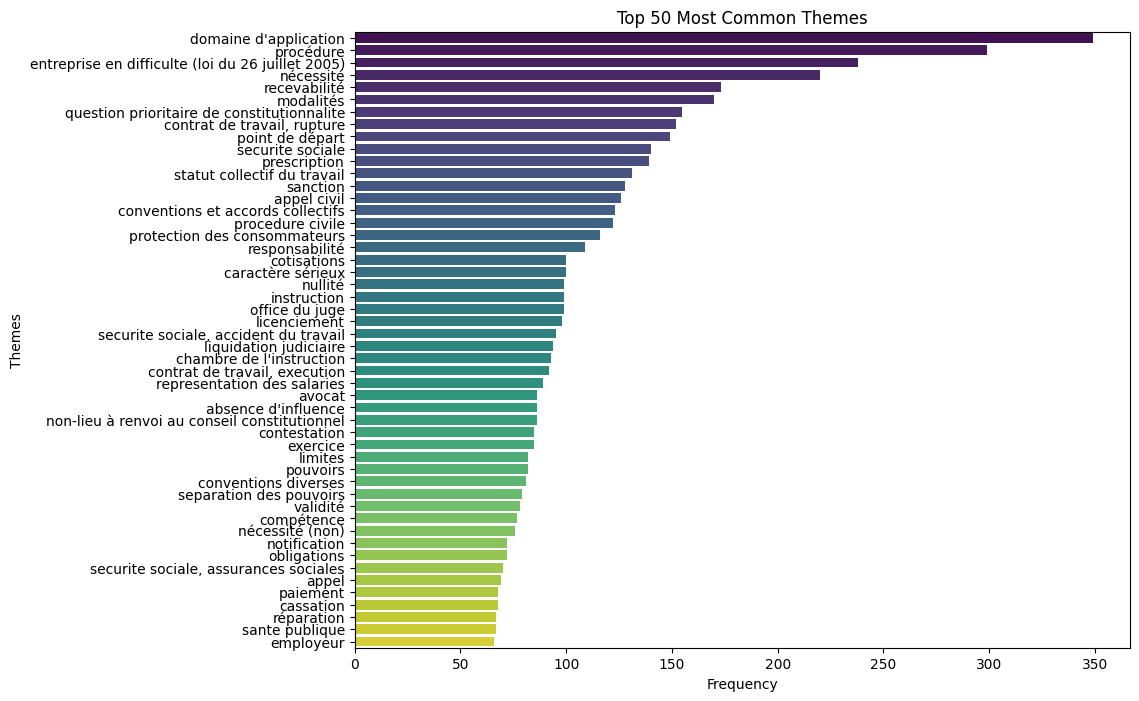

In [7]:
### GRAPH FOR TOP THEMES IN CASS DECISIONS

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_themes = theme_counts.head(50)
sns.barplot(x=top_themes.values, y=top_themes.index, palette="viridis")

plt.xlabel('Frequency')
plt.ylabel('Themes')
plt.title('Top 50 Most Common Themes')
plt.show()

We first wanted to find what themes or areas of French national law made the most references to EU law in their decisions. This was done by using the function “explode” to separate the list of themes into individual elements.

When first rendered, the most common terms were often terms that had little actual meaning within an EU context (such as "preuve"), so we decided to exclude certain themes.

We see from the results that an  overall theme is contract and labour law, with many individual themes such as “enterprise en difficulté”, "contrat de travail rupture”, “statut collectif du travail”, “représentation des salariés”.

Especially interesting in the COVID context is the “santé publique” term listed in the top 50 most common terms.

  * Travel within and outside French borders was heavily restricted during the pandemic between March 2020 and June 2021 for reasons of national public health in order to restrict the spread of the virus.
  * However, these restrictions had to stay in compliance with the freedom of movement, one of the four pillars of the EU, which explains why a matter of national public health would be heavily linked with EU law.
  https://www.eca.europa.eu/Lists/ECADocuments/SR22_13/SR_free-movement-phase-I_EN.pdf

#II. Case Outcomes

#Does referencing EU law have an impact on how cases are decided?

In [9]:
unique_solutions_counts = df_france[["id", "number", "solution"]].drop_duplicates()["solution"].value_counts()
unique_solutions_counts

rejet             10897
cassation          5138
other               293
irrecevabilite      255
qpcother            205
annulation           71
qpc                  58
decheance            55
avis                 53
renvoi               42
nonlieu               7
rabat                 6
designation           4
Name: solution, dtype: int64

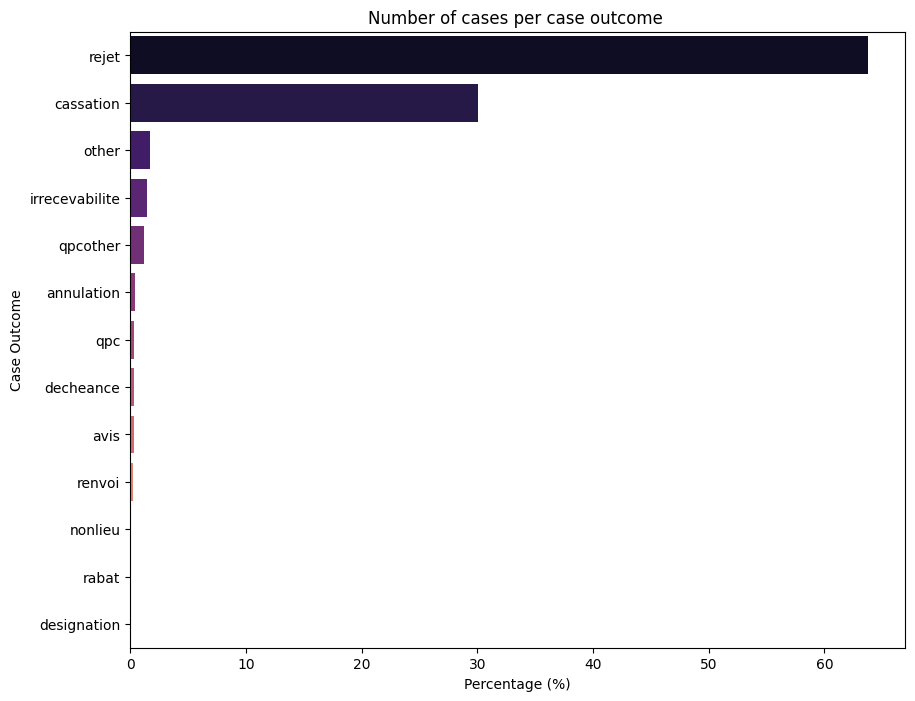

In [10]:
#Bar graph
percentage_counts = df_france[["id", "number", "solution"]].drop_duplicates()["solution"].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(
    data=percentage_counts.reset_index(),
    y="index",
    x="solution",
    palette="magma",
    ax=ax
)

ax.set(xlabel="Percentage (%)", ylabel="Case Outcome")
plt.title('Number of cases per case outcome ')
plt.show()

In [11]:
import datetime

df_france_solutions = df_france[["id", "number", "solution", "decision_date"]].drop_duplicates() # duplicates made from keyword column
df_france_solutions["solution"] = df_france_solutions["solution"].replace({'qpcother': 'qpc', "rabat": "other", "decheance": "other", "nonlieu": "other", "renvoi": "other"})
print(df_france_solutions)

solution_counts = df_france_solutions['solution'].value_counts()
solution_counts

                          id     number        solution decision_date
0   5fca97e33af51f8cc4798830  16-19.731           rejet    2018-03-14
1   62a9778dc8dc0d05e55423e3  21-10.742       cassation    2022-06-15
2   61f0f2367743e3330ccf0756  20-21.542       cassation    2022-01-26
3   62a97782c8dc0d05e55423dd  18-24.850       cassation    2022-06-15
4   5fca587f02d51e27166a576c  18-24.850           other    2020-05-13
..                       ...        ...             ...           ...
45  627e62a8cef29c057d48bff8  22-81.090           rejet    2022-05-10
46  61bc35c51e5d9da61a472564  21-85.771           rejet    2021-12-14
47  5fe1b5e20767eeba3869cb23  20-80.279  irrecevabilite    2020-12-16
48  5fca4cccfc2d067a80a7b7c7  20-85.124       cassation    2020-12-01
49  5fca8bfc1d26a87e3ef72ce3  16-27.649           rejet    2018-06-21

[17084 rows x 4 columns]


rejet             10897
cassation          5138
other               403
qpc                 263
irrecevabilite      255
annulation           71
avis                 53
designation           4
Name: solution, dtype: int64

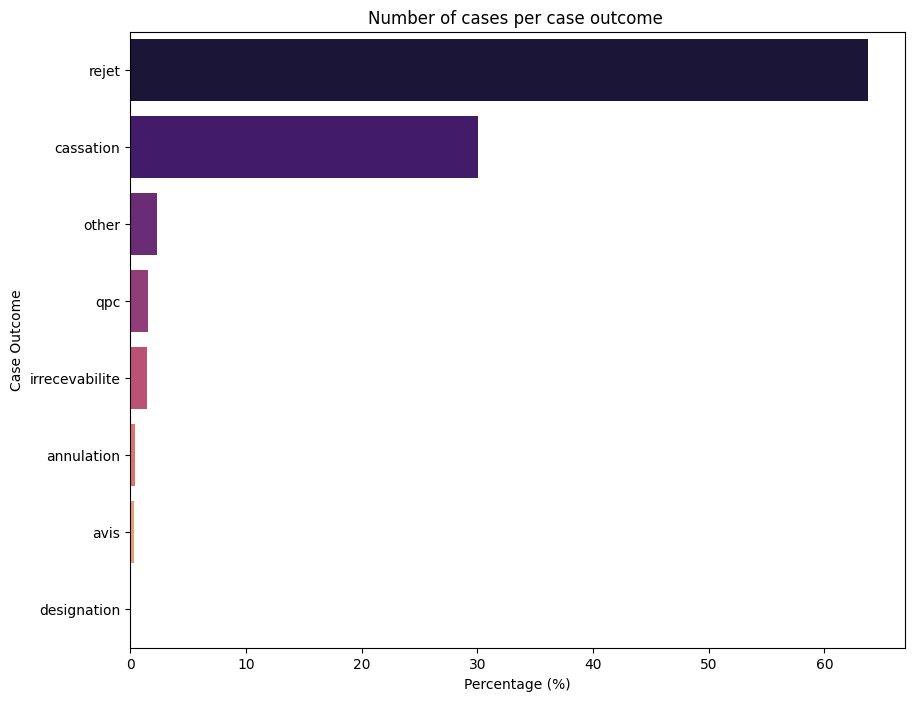

In [12]:
#Bar graph
percentage_counts = df_france_solutions['solution'].str.lower().value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(
    data=percentage_counts.reset_index(),
    y="index",
    x="solution",
    palette="magma",
    ax=ax
)

ax.set(xlabel="Percentage (%)", ylabel="Case Outcome")
plt.title('Number of cases per case outcome ')
plt.show()

We first listed the different types of outcomes for cases, which rendered 13 different types. We decided to limit this to the main ones allowing for easier visualisation of the results and grouped the outcomes with fewer results into the already existing category “other”. So we focused on: rejet, cassation, other, npc, irrecevabilité, annulation, avis and désignation.

This clearly showed that the largest proportion of cases are dismissed, at 64%, followed by cassation at just over 30%. It is also interesting to note that the fourth most common outcome is “qpc” (although technically third largest because “other” is made up of multiple possible outcomes), highlighting the role of the Cour de Cassation in seizing the Conseil constitutionnel on a matter of constitutionality (although the number of QPC decisions remains quite low).

This is also  interesting in an EU setting, as the question of EU supra-constitutionality is a growing matter of debate for national courts and jurisdictions.

#How are cases decided over time?


<ipython-input-13-895257d3daa9>:9: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


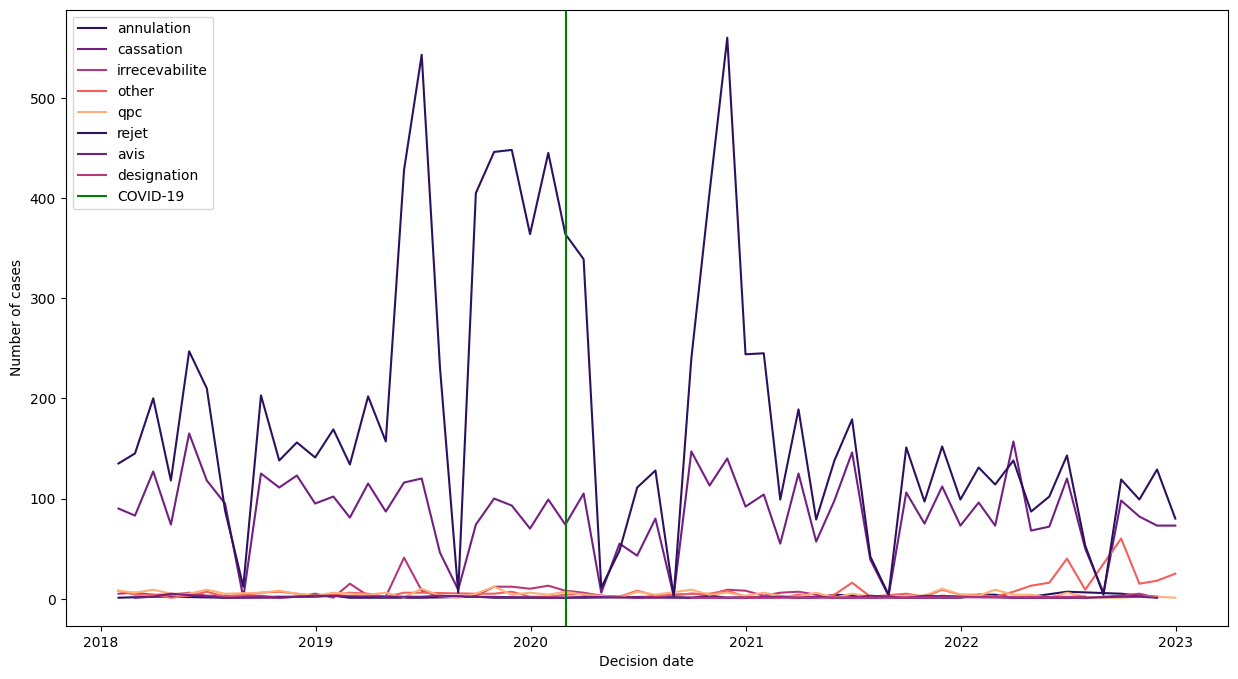

In [13]:
df_france_solutions["decision_date"] = pd.to_datetime(df_france_solutions["decision_date"])

# Grouping by 'decision_date' and 'solution' and counting number of cases per month
df_france_sol_group = df_france_solutions.set_index("decision_date")[["solution", "id", "number"]].groupby([pd.Grouper(freq='1M'), 'solution']).count().reset_index()
df_france_sol_group["decision_month"] = df_france_sol_group["decision_date"].dt.month

plt.figure(figsize=(15, 8))

ax = sns.lineplot(
    x="decision_date",
    y="number",
    hue="solution",
    palette=sns.color_palette("magma", n_colors=5),
    data=df_france_sol_group,
)

# Line indicating the start of Covid
plt.axvline(x=datetime.datetime(2020, 3, 1), color="green", label='COVID-19')

ax.set(xlabel="Decision date", ylabel="Number of cases")
plt.legend(loc="upper left")
plt.show()

We then plotted the filtered solutions against decision dates, to see if there was a change in outcomes over time. Instead of showing outcomes per specific date we grouped the dates per month, allowing for clearer visualisation.

The graph clearly shows how the majority of cases are dismissed. There was a massive spike in dismissals in early 2019 (it is unclear why exactly, although the Courts adopted new policies in 2019 about the physical formatting/rendering of  decisions, and people may have been able to better understand how to 'seize' the court).

We do clearly notice the effect of COVID 19 on the Court and the rendering of decisions, with a drastic drop in activity in early 2020. This did not however affect the outcomes of the decisions themselves (proportionally), except for a spike in dismissals in late 2020, perhaps as a result of earlier inactivity and because of claims of individual rights' violations under restrictive COVID measures.

#Is there a relationship between the different areas of French law that reference  EU law and the case outcome?

In [14]:
df_france_exploded = df_france[["id", "number", "solution", "themes"]].explode("themes")
df_france_exploded = df_france_exploded[~df_france_exploded.isin(excluded_terms)]

df_france_exploded["solution"] = df_france_exploded["solution"].replace({'qpcother': 'qpc', "rabat": "other", "decheance": "other", "nonlieu": "other", "renvoi": "other"})

df_france_exploded = df_france_exploded.drop_duplicates() # drop duplicates after because

df_france_themes = df_france_exploded.groupby(["themes", "solution"]).size().to_frame(name = "counts").reset_index().sort_values("counts", ascending=False)
df_france_themes["prop"] = df_france_themes["counts"] / df_france_themes.groupby("themes")["counts"].transform("sum")
df_france_themes = df_france_themes.merge(theme_counts.to_frame(name = "unique_counts").rename_axis("themes").reset_index())

df_france_themes

,themes,solution,counts,prop,unique_counts
0,domaine d'application,cassation,180,0.515759,349
1,domaine d'application,rejet,162,0.464183,349
2,domaine d'application,avis,3,0.008596,349
3,domaine d'application,annulation,2,0.005731,349
4,domaine d'application,irrecevabilite,1,0.002865,349
...,...,...,...,...,...
15543,décision de rétractation,cassation,1,1.000000,1
15544,décision de sursis,cassation,1,0.500000,2
15545,décision de sursis,rejet,1,0.500000,2
15546,décision de transfert intervenue avant le placement en rétention,cassation,1,1.000000,1


Important to note here is that the unique themes are cross-referenced with unique solutions. More individual themes lead to cassations, which does not however mean there are more overall cassations (indeed, there are more dismissals).

In [15]:
df_france_exploded.groupby(["themes", "solution"]).size().to_frame(name = "counts").reset_index().sort_values("counts", ascending=False)

,themes,solution,counts
5384,domaine d'application,cassation,180
12053,procédure,cassation,169
5387,domaine d'application,rejet,162
12727,question prioritaire de constitutionnalite,qpc,155
10528,nécessité,cassation,140
...,...,...,...
5873,décision de rétractation,cassation,1
5874,décision de sursis,cassation,1
5875,décision de sursis,rejet,1
5876,décision de transfert intervenue avant le placement en rétention,cassation,1


The new data frame here consists of the filtered and unique themes and filtered case outcomes. Each theme was then cross-referenced with the different outcomes, allowing us to count how many times a specific theme led to a specific solution. For instance, “domaine d’application”  led to 179 cassations, 162 dismissals, etc.

<ipython-input-29-58f3bcda7d72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_themes_plot["Case outcome"] = df_themes_plot["solution"]
<ipython-input-29-58f3bcda7d72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_themes_plot["perc"] = df_themes_plot["prop"] * 100


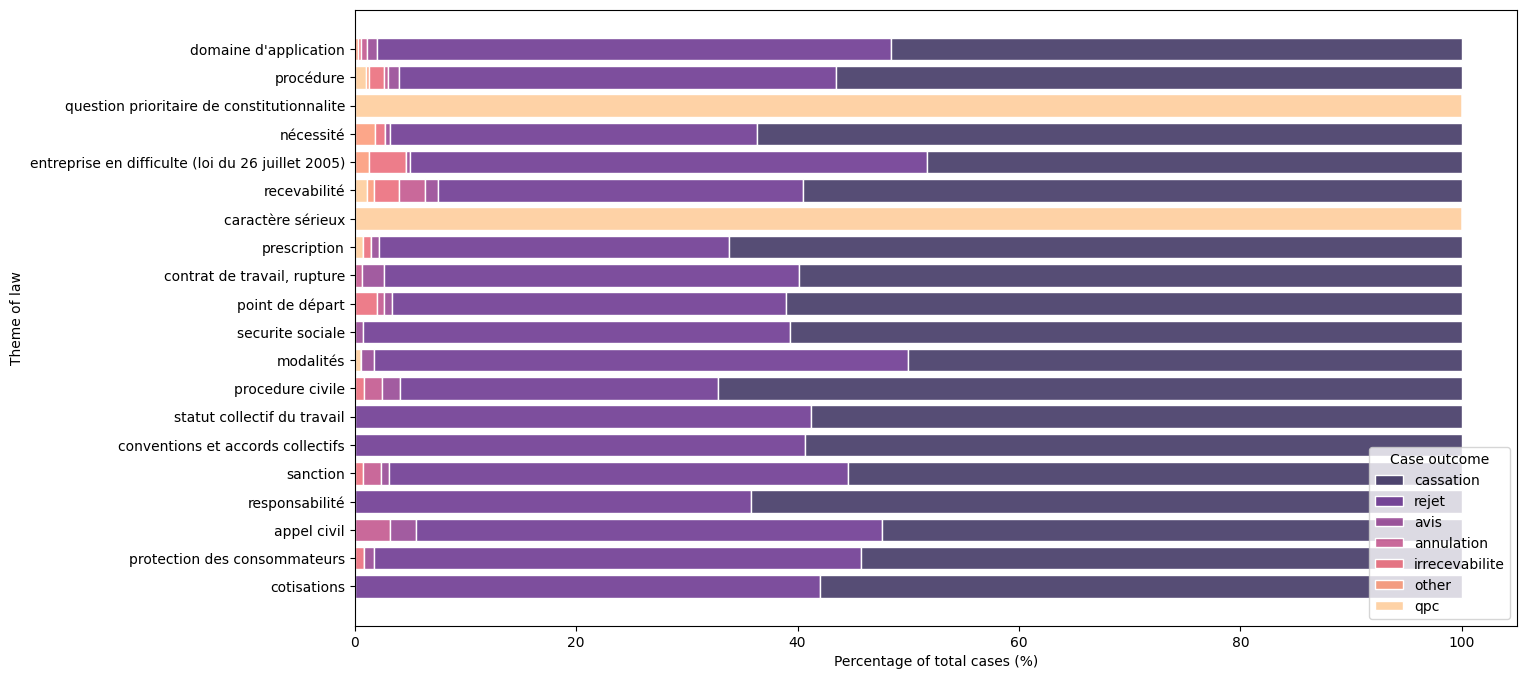

In [29]:
df_themes_plot = df_france_themes[df_france_themes["unique_counts"] >= 100]
df_themes_plot["Case outcome"] = df_themes_plot["solution"]
df_themes_plot["perc"] = df_themes_plot["prop"] * 100

plt.figure(figsize=(15,8))

ax = sns.histplot(
    df_themes_plot,
    y='themes',
    weights="perc",
    hue="Case outcome",
    multiple='stack',
    palette=sns.color_palette("magma", n_colors=7),
    edgecolor='white',
    shrink=0.8
)

ax.set(xlabel="Percentage of total cases (%)", ylabel="Theme of law")

plt.show()

<ipython-input-17-4206139244e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_themes_plot["Case outcome"] = df_themes_plot["solution"]


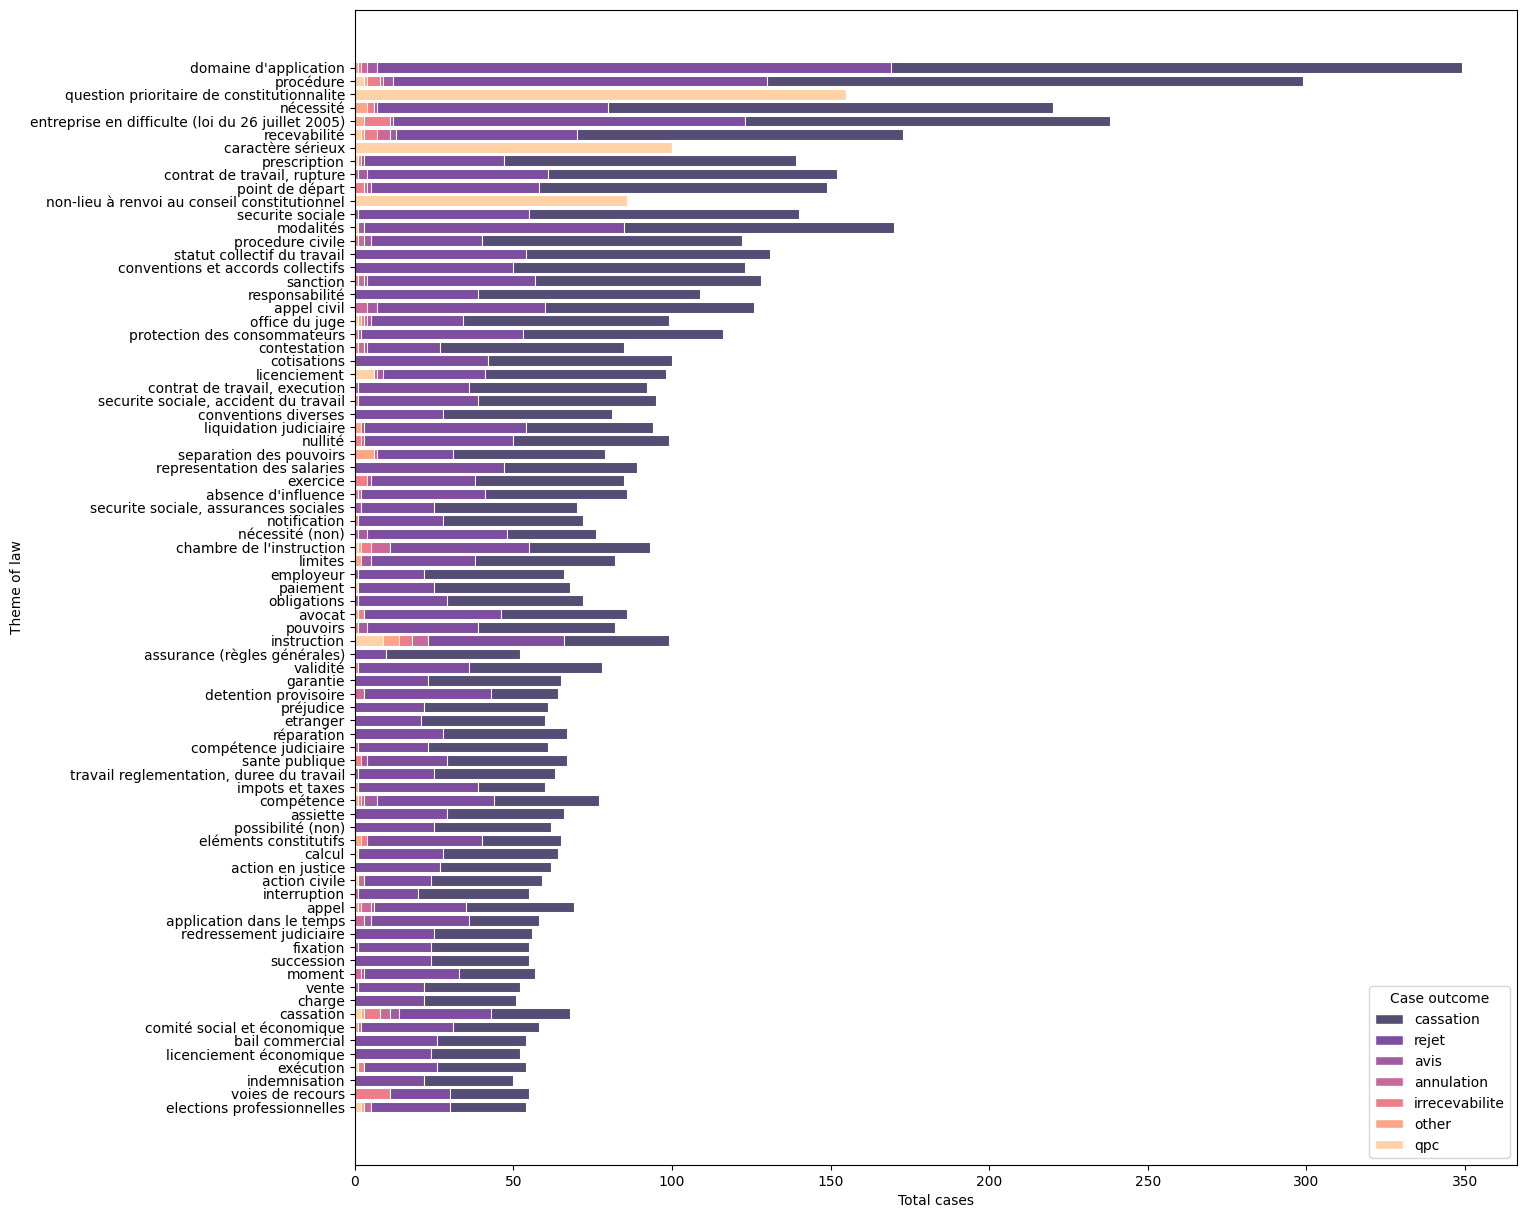

In [17]:
df_themes_plot = df_france_themes[df_france_themes["unique_counts"] >= 50]
df_themes_plot["Case outcome"] = df_themes_plot["solution"]

plt.figure(figsize=(15,15))

ax = sns.histplot(
    df_themes_plot,
    y='themes',
    weights="counts",
    hue="Case outcome",
    multiple='stack',
    palette=sns.color_palette("magma", n_colors=7),
    edgecolor='white',
    shrink=0.8
)

ax.set(xlabel="Total cases", ylabel="Theme of law")

plt.show()

The data was rendered into a stacked bar graph, both for percentage value and total number of cases. What we see here that the majority of cases lead to cassation, in contrast to the overall higher number of rejections by the court. This is because the data was filtered by the count of unique themes, which have a different distribution of outcomes.

Interesting here is the relatively high percentage of cases referring to EU law that led to a QPC in the area of "licenciement". This could be because EU law has better protection for unfair dismissals (Under Charter of Fundamental rights: "la protection en cas de licenciement injustifié (article 30)). This also points to th conflicts of jurisdiction between national courts and 'supra-constitutional' entities like the ECJ, which national courts will often resist. Indeed, the CC held that EU directives must be adopted within French law but that it could not go against the ‘consitutional identity’ of France.
(https://fra.europa.eu/sites/default/files/fra_uploads/fra-2019-eu-charter-in-france_fr.pdf)  

#III. References to EU law

##Has there been a change in the EU instrument used in the decisions of the Cour de Cassation?

##Is there a relationship between the reference to specific EU instruments in decisions and the outcome of the decision over time?
  
##Is there a link with COVID?

In [18]:
df_france["keyword"].unique()

array(['règlement UE', 'directive',
       "CHARTE DES DROITS FONDAMENTAUX DE L'UNION EUROPÉENNE", 'TFUE',
       "Traité sur le fonctionnement de l'Union européenne",
       "Traité sur l'Union européenne"], dtype=object)

In [19]:
df_france['keyword'] = df_france['keyword'].replace({"TFUE": "Traité sur le fonctionnement de l'Union européenne"})

keyword_counts = df_france[["id", "number", "solution", "keyword"]].drop_duplicates()['keyword'].value_counts()

keyword_counts

Traité sur le fonctionnement de l'Union européenne      7493
Traité sur l'Union européenne                           7402
CHARTE DES DROITS FONDAMENTAUX DE L'UNION EUROPÉENNE    7376
règlement UE                                            7372
directive                                               2796
Name: keyword, dtype: int64

In [20]:
df_france["decision_date"] = pd.to_datetime(df_france["decision_date"])

In [21]:
df_france_line = df_france[["id", "number", "solution", "decision_date", "keyword"]].drop_duplicates()
df_france_line = df_france_line.set_index("decision_date").groupby([pd.Grouper(freq='1M'), 'keyword']).count().reset_index()
df_france_line["decision_month"] = df_france_line["decision_date"].dt.month
df_france_line

,decision_date,keyword,id,number,solution,decision_month
0,2018-01-31,CHARTE DES DROITS FONDAMENTAUX DE L'UNION EUROPÉENNE,100,100,100,1
1,2018-01-31,Traité sur l'Union européenne,136,136,136,1
2,2018-01-31,Traité sur le fonctionnement de l'Union européenne,80,80,80,1
3,2018-01-31,directive,56,56,56,1
4,2018-01-31,règlement UE,81,81,81,1
...,...,...,...,...,...,...
291,2022-12-31,CHARTE DES DROITS FONDAMENTAUX DE L'UNION EUROPÉENNE,74,74,74,12
292,2022-12-31,Traité sur l'Union européenne,85,85,85,12
293,2022-12-31,Traité sur le fonctionnement de l'Union européenne,48,48,48,12
294,2022-12-31,directive,23,23,23,12


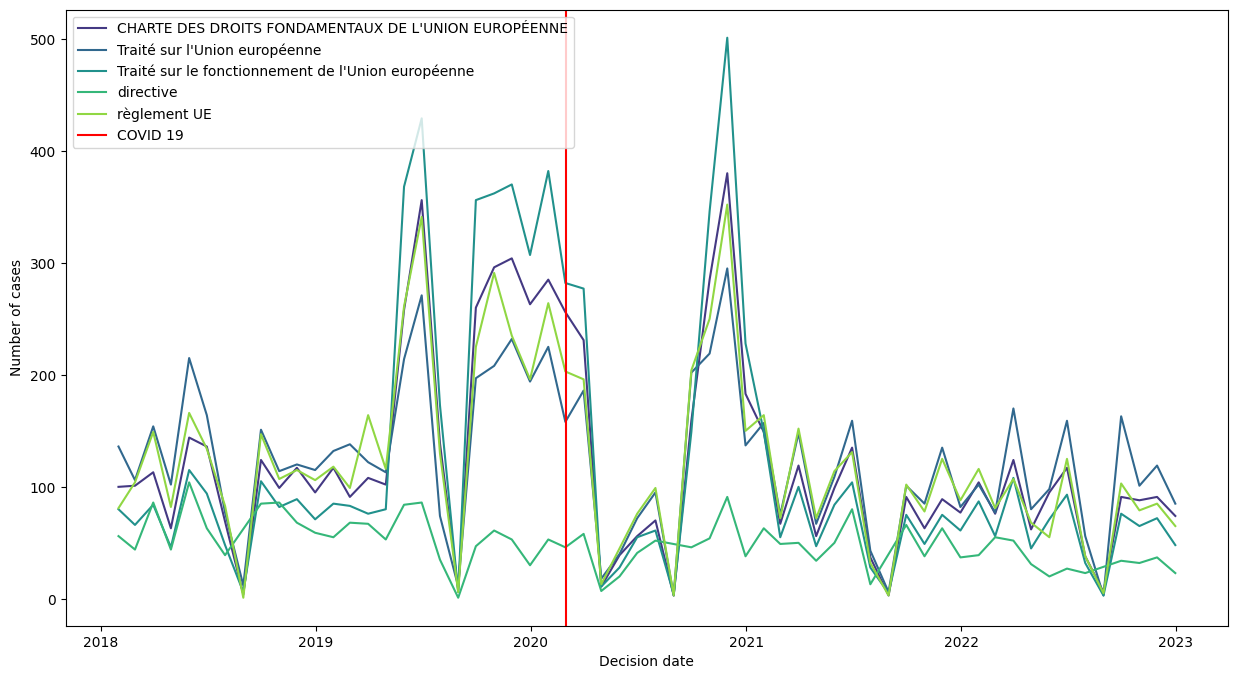

In [22]:
import datetime
plt.figure(figsize=(15,8))

ax = sns.lineplot(
    x="decision_date",
    y="number",
    hue="keyword",
    palette=sns.color_palette("viridis", n_colors=5),
    data=df_france_line,
)

# line at Covid
plt.axvline(x=datetime.datetime(2020, 3, 1), color="red", label="COVID 19")

ax.set(xlabel="Decision date", ylabel="Number of cases")
plt.legend(loc="upper left")
plt.show()

The Traité du fonctionnement de l'UE is most referenced in Cour de Cassation decisions.

COVID shows a drastic drop in decisions rendered, but also shows that immediately following the crisis there was greater reference to the Charter of Fundamental Rights of the EU proportionally to other years. This can be explained by the number of cases that were brought forth claiming breaches of rights caused by the strict protective measures of the state during this time,  especially on the freedom of movement, which is a fundamental right of the Charter (https://www.frontiersin.org/articles/10.3389/fpos.2020.618664/full).

The overall number of cases is much lower than on the graph that plots outcomes over time because we only filtered for a number of EU instruments and not all. This could of course be amended when looking for a specific EU instrument.

<ipython-input-23-9a2d439f6f90>:10: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


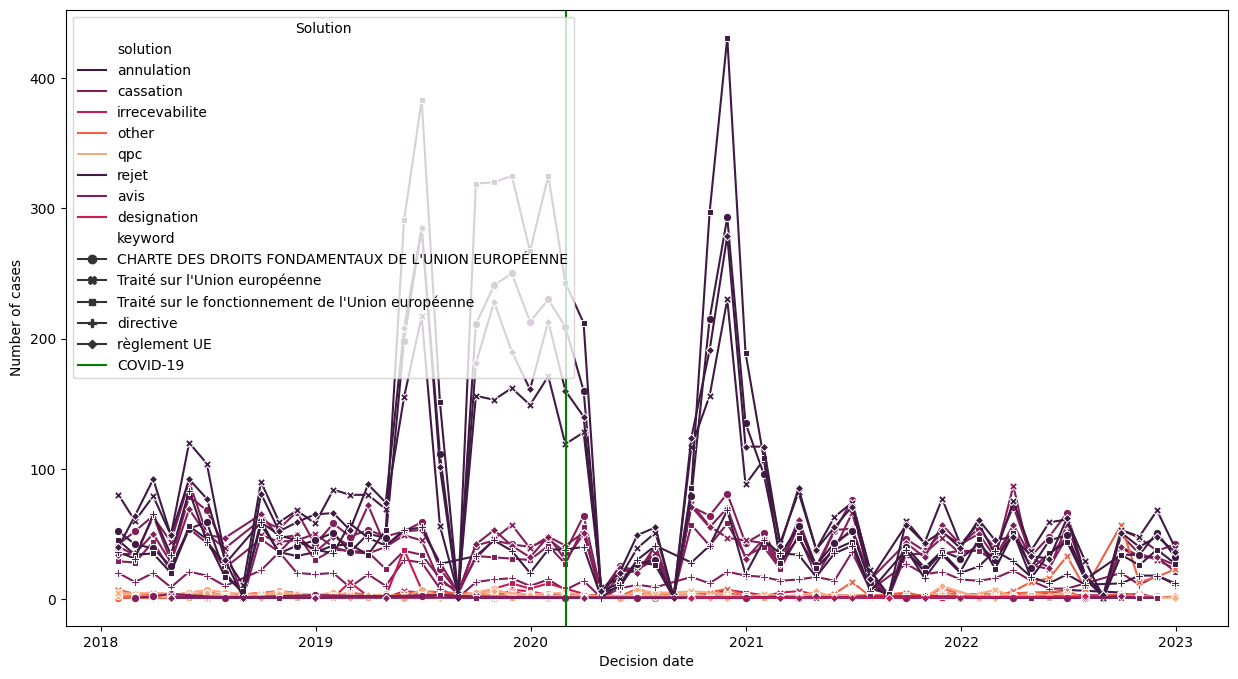

In [23]:
# outcomes and EU instrument
df_france_solutions = df_france[["id", "number", "solution", "decision_date", "keyword"]].drop_duplicates()
df_france_solutions["solution"] = df_france_solutions["solution"].replace({'qpcother': 'qpc', "rabat": "other", "decheance": "other", "nonlieu": "other", "renvoi": "other"})
df_france_solutions["decision_date"] = pd.to_datetime(df_france_solutions["decision_date"])

df_france_grouped = df_france_solutions.groupby([pd.Grouper(key='decision_date', freq='1M'), 'keyword', 'solution']).count().reset_index()

plt.figure(figsize=(15, 8))

ax = sns.lineplot(
    x="decision_date",
    y="id",
    hue="solution",
    style="keyword",
    markers=True,
    dashes=False,
    palette=sns.color_palette("rocket", n_colors=len(df_france_grouped['keyword'].unique())),
    data=df_france_grouped
)

plt.axvline(x=datetime.datetime(2020, 3, 1), color="green", label='COVID-19')

ax.set(xlabel="Decision date", ylabel="Number of cases")
plt.legend(title='Solution', loc='upper left')
plt.show()

The keyword column has duplicates, which means each case does not have a unique keyword. So we are plotting cases coloured by keyword, but the same case can have multiple keywords.

The general trend seems to be that no matter what EU instrument is referred to in the decision, it will lead to a dismissal (although there is more variation recently).

The important exception to this trend is that the Charter of Fundamental Rights was the most cited EU document when decisions led to a cassation in late 2020.

This highlights again the impact of COVID on decisions of the Cour de cassation and especially within the EU context. Following COVID and the restrictions many governments imposed, there were many claims of violations of individual freedoms, which are enshrined in the Charter.

# DATAFRAME ECJ

We extracted the data for this dataframe from the ECJ Curia website, setting the parameters for "france" and "allemagne" to filter decicions that would involve these 2 countries.

We decided to use a loop that would parse through specific elements of the webpage to extract the data we wanted to store, including the date, the case number, the outcome, and the "theme" or area of law.

Unfortunately, we did not manage to extract the names of the parties as the element under which this was stored was the same as for the theme so the code would not print it.

We filtered the decisions for the judgements only and deleted any duplicate results by filtering out duplicates from the Case Number column.

Regarding the themes, we could not analyse these as they are in a format that would not allow this (the words are often written one after the other so we could not always extract individual themes).

In [24]:
### ECJ ###

import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

urls = [
    'https://curia.europa.eu/juris/documents.jsf?page=1&nat=or&mat=or&pcs=Oor&jur=C&for=&jge=&dates=%2524type%253Dpro%2524mode%253DfromTo%2524from%253D2018.01.01%2524to%253D2023.01.01&language=en&pro=&etat=clot&cit=none%252CC%252CCJ%252CR%252C2008E%252C%252C%252C%252C%252C%252C%252C%252C%252C%252Ctrue%252Cfalse%252Cfalse&oqp=&td=%3BALL&avg=&lgrec=en&parties=allemagne%252C%2Bfrance&lg=&cid=357337',
    'https://curia.europa.eu/juris/documents.jsf?page=2&nat=or&mat=or&pcs=Oor&jur=C&for=&jge=&dates=%2524type%253Dpro%2524mode%253DfromTo%2524from%253D2018.01.01%2524to%253D2023.01.01&language=en&pro=&etat=clot&cit=none%252CC%252CCJ%252CR%252C2008E%252C%252C%252C%252C%252C%252C%252C%252C%252C%252Ctrue%252Cfalse%252Cfalse&oqp=&td=%3BALL&avg=&lgrec=en&parties=allemagne%252C%2Bfrance&lg=&cid=365912',
    'https://curia.europa.eu/juris/documents.jsf?page=3&nat=or&mat=or&pcs=Oor&jur=C&for=&jge=&dates=%2524type%253Dpro%2524mode%253DfromTo%2524from%253D2018.01.01%2524to%253D2023.01.01&language=en&pro=&etat=clot&cit=none%252CC%252CCJ%252CR%252C2008E%252C%252C%252C%252C%252C%252C%252C%252C%252C%252Ctrue%252Cfalse%252Cfalse&oqp=&td=%3BALL&avg=&lgrec=en&parties=allemagne%252C%2Bfrance&lg=&cid=365912',
    'https://curia.europa.eu/juris/documents.jsf?page=4&nat=or&mat=or&pcs=Oor&jur=C&for=&jge=&dates=%2524type%253Dpro%2524mode%253DfromTo%2524from%253D2018.01.01%2524to%253D2023.01.01&language=en&pro=&etat=clot&cit=none%252CC%252CCJ%252CR%252C2008E%252C%252C%252C%252C%252C%252C%252C%252C%252C%252Ctrue%252Cfalse%252Cfalse&oqp=&td=%3BALL&avg=&lgrec=en&parties=allemagne%252C%2Bfrance&lg=&cid=365912',
    'https://curia.europa.eu/juris/documents.jsf?page=5&nat=or&mat=or&pcs=Oor&jur=C&for=&jge=&dates=%2524type%253Dpro%2524mode%253DfromTo%2524from%253D2018.01.01%2524to%253D2023.01.01&language=en&pro=&etat=clot&cit=none%252CC%252CCJ%252CR%252C2008E%252C%252C%252C%252C%252C%252C%252C%252C%252C%252Ctrue%252Cfalse%252Cfalse&oqp=&td=%3BALL&avg=&lgrec=en&parties=allemagne%252C%2Bfrance&lg=&cid=365912',
    'https://curia.europa.eu/juris/documents.jsf?page=6&nat=or&mat=or&pcs=Oor&jur=C&for=&jge=&dates=%2524type%253Dpro%2524mode%253DfromTo%2524from%253D2018.01.01%2524to%253D2023.01.01&language=en&pro=&etat=clot&cit=none%252CC%252CCJ%252CR%252C2008E%252C%252C%252C%252C%252C%252C%252C%252C%252C%252Ctrue%252Cfalse%252Cfalse&oqp=&td=%3BALL&avg=&lgrec=en&parties=allemagne%252C%2Bfrance&lg=&cid=365912'
]

dfs = []

for url in urls:
    response = requests.get(url)

    if response.status_code == 200:
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')
        table = soup.find('table', class_='detail_table_documents')

        if table:
            column_aff_data = table.find_all('td', class_='table_cell_aff')
            column_aff_values = [data.get_text(strip=True) for data in column_aff_data]

            df_Case = pd.DataFrame({'Case': column_aff_values})
            df_Case = df_Case[df_Case['Case'] != '']
            df_Case.reset_index(drop=True, inplace=True)

            dfs.append(df_Case)

df_Case = pd.concat(dfs, ignore_index=True)

text_segments_per_cell = []
all_dates = []
all_data = []

pattern = r'(Request|Application|Order|Judgment|Opinion|Removal|Abstract)'

for url in urls:
    response = requests.get(url)

    if response.status_code == 200:
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')
        table = soup.find('table', class_='detail_table_documents')


        date_elements = soup.find_all(class_='table_cell_date')
        dates = [date.get_text(strip=True) for date in date_elements]
        all_dates.extend(dates[1:])


        elements = soup.find_all(class_='table_cell_links_curia')
        data = [element.get_text(strip=True) for element in elements]
        all_data.extend(data[1:])

        if table:
            rows = table.find_all('tr')

            for row in rows:
                cells = row.find_all('td', class_='table_cell_doc')

                if any(cells):
                    row_text_segments = []

                    for cell in cells:
                        cell_text = cell.get_text(strip=True)


                        matches = re.findall(pattern, cell_text)

                        row_text_segments.append(''.join(matches))

                    if any(row_text_segments):
                        text_segments_per_cell.append(row_text_segments[0])

if not text_segments_per_cell:
    print("No text segments found.")
else:
    df_ECJ_final = pd.DataFrame({"Dates": all_dates, "Case Outcome": text_segments_per_cell, "Subject": all_data, "Case Number": df_Case["Case"].values})

df_ECJ_final

,Dates,Case Outcome,Subject,Case Number
0,25/02/2020,Request,TransportTransport,C-93/20
1,14/08/2020,Application,TransportTransport,C-286/20
2,15/07/2020,Order,TransportTransport,C-286/20
3,10/06/2022,Judgment,Approximation of lawsApproximation of lawsEnvironment,C-525/20
4,05/05/2022,Judgment,Approximation of lawsApproximation of lawsEnvironment,C-525/20
...,...,...,...,...
110,20/07/2018,Judgment,TaxationTaxation,C-39/17
111,14/06/2018,Judgment,TaxationTaxation,C-39/17
112,14/06/2018,Judgment,TaxationTaxation,C-39/17
113,31/01/2018,Opinion,TaxationTaxation,C-39/17


In [25]:
#ECJ judgments

judgment = df_ECJ_final.apply(lambda row: 'Judgment' in ''.join(row), axis=1)
df_ECJ_judgment = df_ECJ_final[judgment].reset_index(drop=True)

In [26]:
#Filtered judgments to only have 1 per case number

df_ECJ_judgment_no_duplicates = df_ECJ_judgment.drop_duplicates(subset='Case Number')
df_ECJ_judgment_filtered = df_ECJ_judgment_no_duplicates.reset_index(drop=True)
df_ECJ_judgment_filtered

,Dates,Case Outcome,Subject,Case Number
0,10/06/2022,Judgment,Approximation of lawsApproximation of lawsEnvironment,C-525/20
1,28/04/2022,Judgment,EnvironmentEnvironment,C-286/21
2,29/01/2021,Judgment,Agriculture and Fisheries-European Agricultural Guidance and Guarantee Fund (EAGGF)Agriculture and Fisheries-European Agricultural Guidance and Guarantee Fund (EAGGF),C-404/19 P
3,26/03/2021,Judgment,Freedom of movement for workersFreedom of movement for workersFreedom of establishmentFreedom to provide services,C-940/19
4,26/11/2021,Judgment,Taxation-Value added taxTaxation-Value added tax,C-80/20
5,21/08/2020,Judgment,"Competition-Agreements, decisions and concerted practicesCompetition-Agreements, decisions and concerted practices",C-606/18 P
6,06/12/2019,Judgment,EnvironmentEnvironment,C-636/18
7,18/02/2022,Judgment,Environment-PollutionEnvironment-Pollution,C-177/19 P
8,04/10/2018,Judgment,Freedom of establishmentFreedom of establishment,C-416/17
9,07/08/2020,Judgment,Provisions governing the institutionsProvisions governing the institutions,C-92/18


In [27]:
from collections import Counter

df = []

#Split themes
unique_subjects = df_ECJ_judgment_filtered['Subject'].unique().tolist()
str(unique_subjects)
split_subjects = [subject.split('-') for subject in unique_subjects]
flattened_list = [item for sublist in split_subjects for item in sublist]
unique_split_themes = list(set(flattened_list))
unique_split_themes
element_counts = Counter(unique_split_themes)
element_counts

Counter({'EnergyEnergyTaxation': 1,
         'TaxationTaxation': 1,
         'EnvironmentEnvironment': 1,
         'Value added tax': 1,
         'Value added taxTaxation': 1,
         'PollutionEnvironment': 1,
         'Common Customs TariffFree movement of goods': 1,
         'Common Customs Tariff': 1,
         'Pollution': 1,
         'Taxation': 1,
         'Approximation of lawsApproximation of lawsEnvironment': 1,
         'Freedom of movement for workersFreedom of movement for workersFreedom of establishmentFreedom to provide services': 1,
         'Environment': 1,
         'Agreements, decisions and concerted practicesCompetition': 1,
         'Approximation of lawsApproximation of lawsFreedom of establishmentFreedom to provide servicesInternal market ': 1,
         'Freedom of establishmentFreedom of establishment': 1,
         'Free movement of goods': 1,
         'Provisions governing the institutionsProvisions governing the institutions': 1,
         ' Principles': 1,
  